In [1]:
import pandas as pds
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,DepthwiseConv2D, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.metrics import Precision, Recall, AUC

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
dataset_dir = ('../input/imagesoasis/Data')

categories = ['Mild Dementia', 'Moderate Dementia', 'Non Demented','Very mild Dementia']

data = []
labels = []

class_counts = {category: 0 for category in categories}

for category in categories:
    path = os.path.join(dataset_dir, category)
    num_images = len(os.listdir(path))
    class_counts[category] = num_images
    print(f"Number of images in {category}: {num_images}")

print("\nTotal number of images:")
for category, count in class_counts.items():
    print(f"{category}: {count}")


Number of images in Mild Dementia: 5002
Number of images in Moderate Dementia: 488
Number of images in Non Demented: 67222
Number of images in Very mild Dementia: 13725

Total number of images:
Mild Dementia: 5002
Moderate Dementia: 488
Non Demented: 67222
Very mild Dementia: 13725


In [7]:
import random
dataset_dir = ('../input/imagesoasis/Data')

categories = ['Mild Dementia', 'Moderate Dementia', 'Non Demented','Very mild Dementia']

# Set a seed for reproducibility
random.seed(50)

data = []
labels = []
undersampled_class_counts = {category: 0 for category in categories}

# Set the desired number of images for undersampling
num_undersample_non_demented = 9000
num_undersample_very_mild_dementia = 7000

for category in categories:
    path = os.path.join(dataset_dir, category)
    num_images = len(os.listdir(path))
    class_num = categories.index(category)

    # For 'Non Demented', limit the number of images
    if category == 'Non Demented':
        images = random.sample(os.listdir(path), min(num_undersample_non_demented, num_images))
    elif category == 'Very mild Dementia':
        images = random.sample(os.listdir(path), min(num_undersample_very_mild_dementia, num_images))
    else:
        images = os.listdir(path)
        
    undersampled_class_counts[category] = len(images)

    print(f"Number of images in {category}: {undersampled_class_counts[category]}")    

    for img in images:
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
        img_array = cv2.resize(img_array, (224, 224))  # Resize the image to 224x224
        data.append([img_array, class_num])

np.random.shuffle(data)


Number of images in Mild Dementia: 5002
Number of images in Moderate Dementia: 488
Number of images in Non Demented: 9000
Number of images in Very mild Dementia: 7000


In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

In [11]:
X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)

X = np.array(X)
y = np.array(y)
# out = np.divide(X,255)

y = to_categorical(y, num_classes=len(categories))

n_splits = 1
test_size = 0.2

stratified_split = StratifiedShuffleSplit(n_splits=n_splits,test_size=test_size,random_state=43)

for train_index, test_index in stratified_split.split(X,y):
  X_t, X_test = X[train_index], X[test_index]
  y_t, y_test = y[train_index], y[test_index]

In [12]:
n_splits = 1
test_size = 0.2

stratified_split = StratifiedShuffleSplit(n_splits=n_splits,test_size=test_size,random_state=43)

for train_index, val_index in stratified_split.split(X_t,y_t):
  X_train, X_val = X_t[train_index], X_t[val_index]
  y_train, y_val = y_t[train_index], y_t[val_index]

In [14]:
from collections import Counter

train_class_counts = Counter(np.argmax(y_train, axis=1))

val_class_counts = Counter(np.argmax(y_val, axis=1))

test_class_counts = Counter(np.argmax(y_test, axis=1))

print("Training Set Class Counts:")
for class_label, count in train_class_counts.items():
    print(f"Class {class_label}: {count} samples")

print("\nValidation Set Class Counts:")
for class_label, count in val_class_counts.items():
    print(f"Class {class_label}: {count} samples")

print("\nTest Set Class Counts:")
for class_label, count in test_class_counts.items():
    print(f"Class {class_label}: {count} samples")


Training Set Class Counts:
Class 3: 4480 samples
Class 0: 3201 samples
Class 2: 5760 samples
Class 1: 312 samples

Validation Set Class Counts:
Class 2: 1440 samples
Class 0: 801 samples
Class 3: 1120 samples
Class 1: 78 samples

Test Set Class Counts:
Class 2: 1800 samples
Class 3: 1400 samples
Class 0: 1000 samples
Class 1: 98 samples


In [15]:
print(len(X_train),len(X_test),len(X_val),len(X_t))

13753 4298 3439 17192


In [49]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_shape = (224, 224, 3)

def attention_module(x):
  avg_pool = layers.GlobalAveragePooling2D()(x)
  max_pool = layers.GlobalMaxPooling2D()(x)

  combined = layers.concatenate([avg_pool, max_pool])
  combined = layers.Reshape((1, 1, combined.shape[1]))(combined)

  dense = layers.Dense(combined.shape[3] // 8,
                       activation = 'relu')(combined)
  dense = layers.Dense(x.shape[-1], activation = 'sigmoid')(dense)

  attention = layers.Reshape((1, 1, x.shape[-1]))(dense)
  attention = layers.Multiply()([x, attention])

  return attention

# Input layer
inputs = keras.Input(shape=input_shape)

# Block 1
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='Conv2D_1')(inputs)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='MaxPooling2D_1')(x)
x = layers.BatchNormalization(name='BatchNormalization_1')(x)

# Block 2
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='Conv2D_2')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='MaxPooling2D_2')(x)
x = layers.BatchNormalization(name='BatchNormalization_2')(x)

# Block 3
x = layers.Conv2D(96, (3, 3), padding='same', activation='relu', name='Conv2D_3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='MaxPooling2D_3')(x)
x = layers.BatchNormalization(name='BatchNormalization_3')(x)

# Block 4
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='Conv2D_4')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='MaxPooling2D_4')(x)
x1 = layers.BatchNormalization(name='BatchNormalization_4')(x)

# Spatial Attention
y1 = layers.MaxPooling2D((2, 2), padding="same", strides=(1, 1), name='MaxPooling2D_y1')(x1)
y2 = layers.AvgPool2D((2, 2), padding="same", strides=(1, 1), name='AvgPool2D_y2')(x1)
concat = layers.Concatenate()([y1, y2])

y4 = layers.Conv2D(16, (3, 3), padding='same', dilation_rate=2, name='Conv2D_y2')(concat)

y41 = layers.Conv2D(16, (3, 3), padding='same', dilation_rate=4, name='Conv2D_y')(concat)

y4 = layers.BatchNormalization(name='BatchNormalization_y')(y4)
y4 = layers.ReLU()(y4)

# Skip Connection (M)
concat_m = layers.Concatenate()([y4, x1, y41])
z = layers.MaxPooling2D((2, 2), strides=(2, 2), name='MaxPooling2D_z')(concat_m)

# Block 5
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='Conv2D_5')(x1)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='MaxPooling2D_5')(x)
x = layers.BatchNormalization(name='BatchNormalization_5')(x)

# Block 6
x = layers.DepthwiseConv2D((3, 3), padding="same", activation='relu', name='DepthwiseConv2D_1')(x)
x = layers.BatchNormalization(name='BatchNormalization_6')(x)

# Block 7
concat_gap = layers.Concatenate()([x, z])
gap1 = layers.GlobalAveragePooling2D(name='GlobalAveragePooling2D_1')(concat_gap)

# Output layer
outputs = layers.Dense(4, activation='softmax', name='Output_Dense')(gap1)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv2D_1 (Conv2D)           (None, 224, 224, 32)         896       ['input_6[0][0]']             
                                                                                                  
 MaxPooling2D_1 (MaxPooling  (None, 112, 112, 32)         0         ['Conv2D_1[0][0]']            
 2D)                                                                                              
                                                                                                  
 BatchNormalization_1 (Batc  (None, 112, 112, 32)         128       ['MaxPooling2D_1[0][0]']

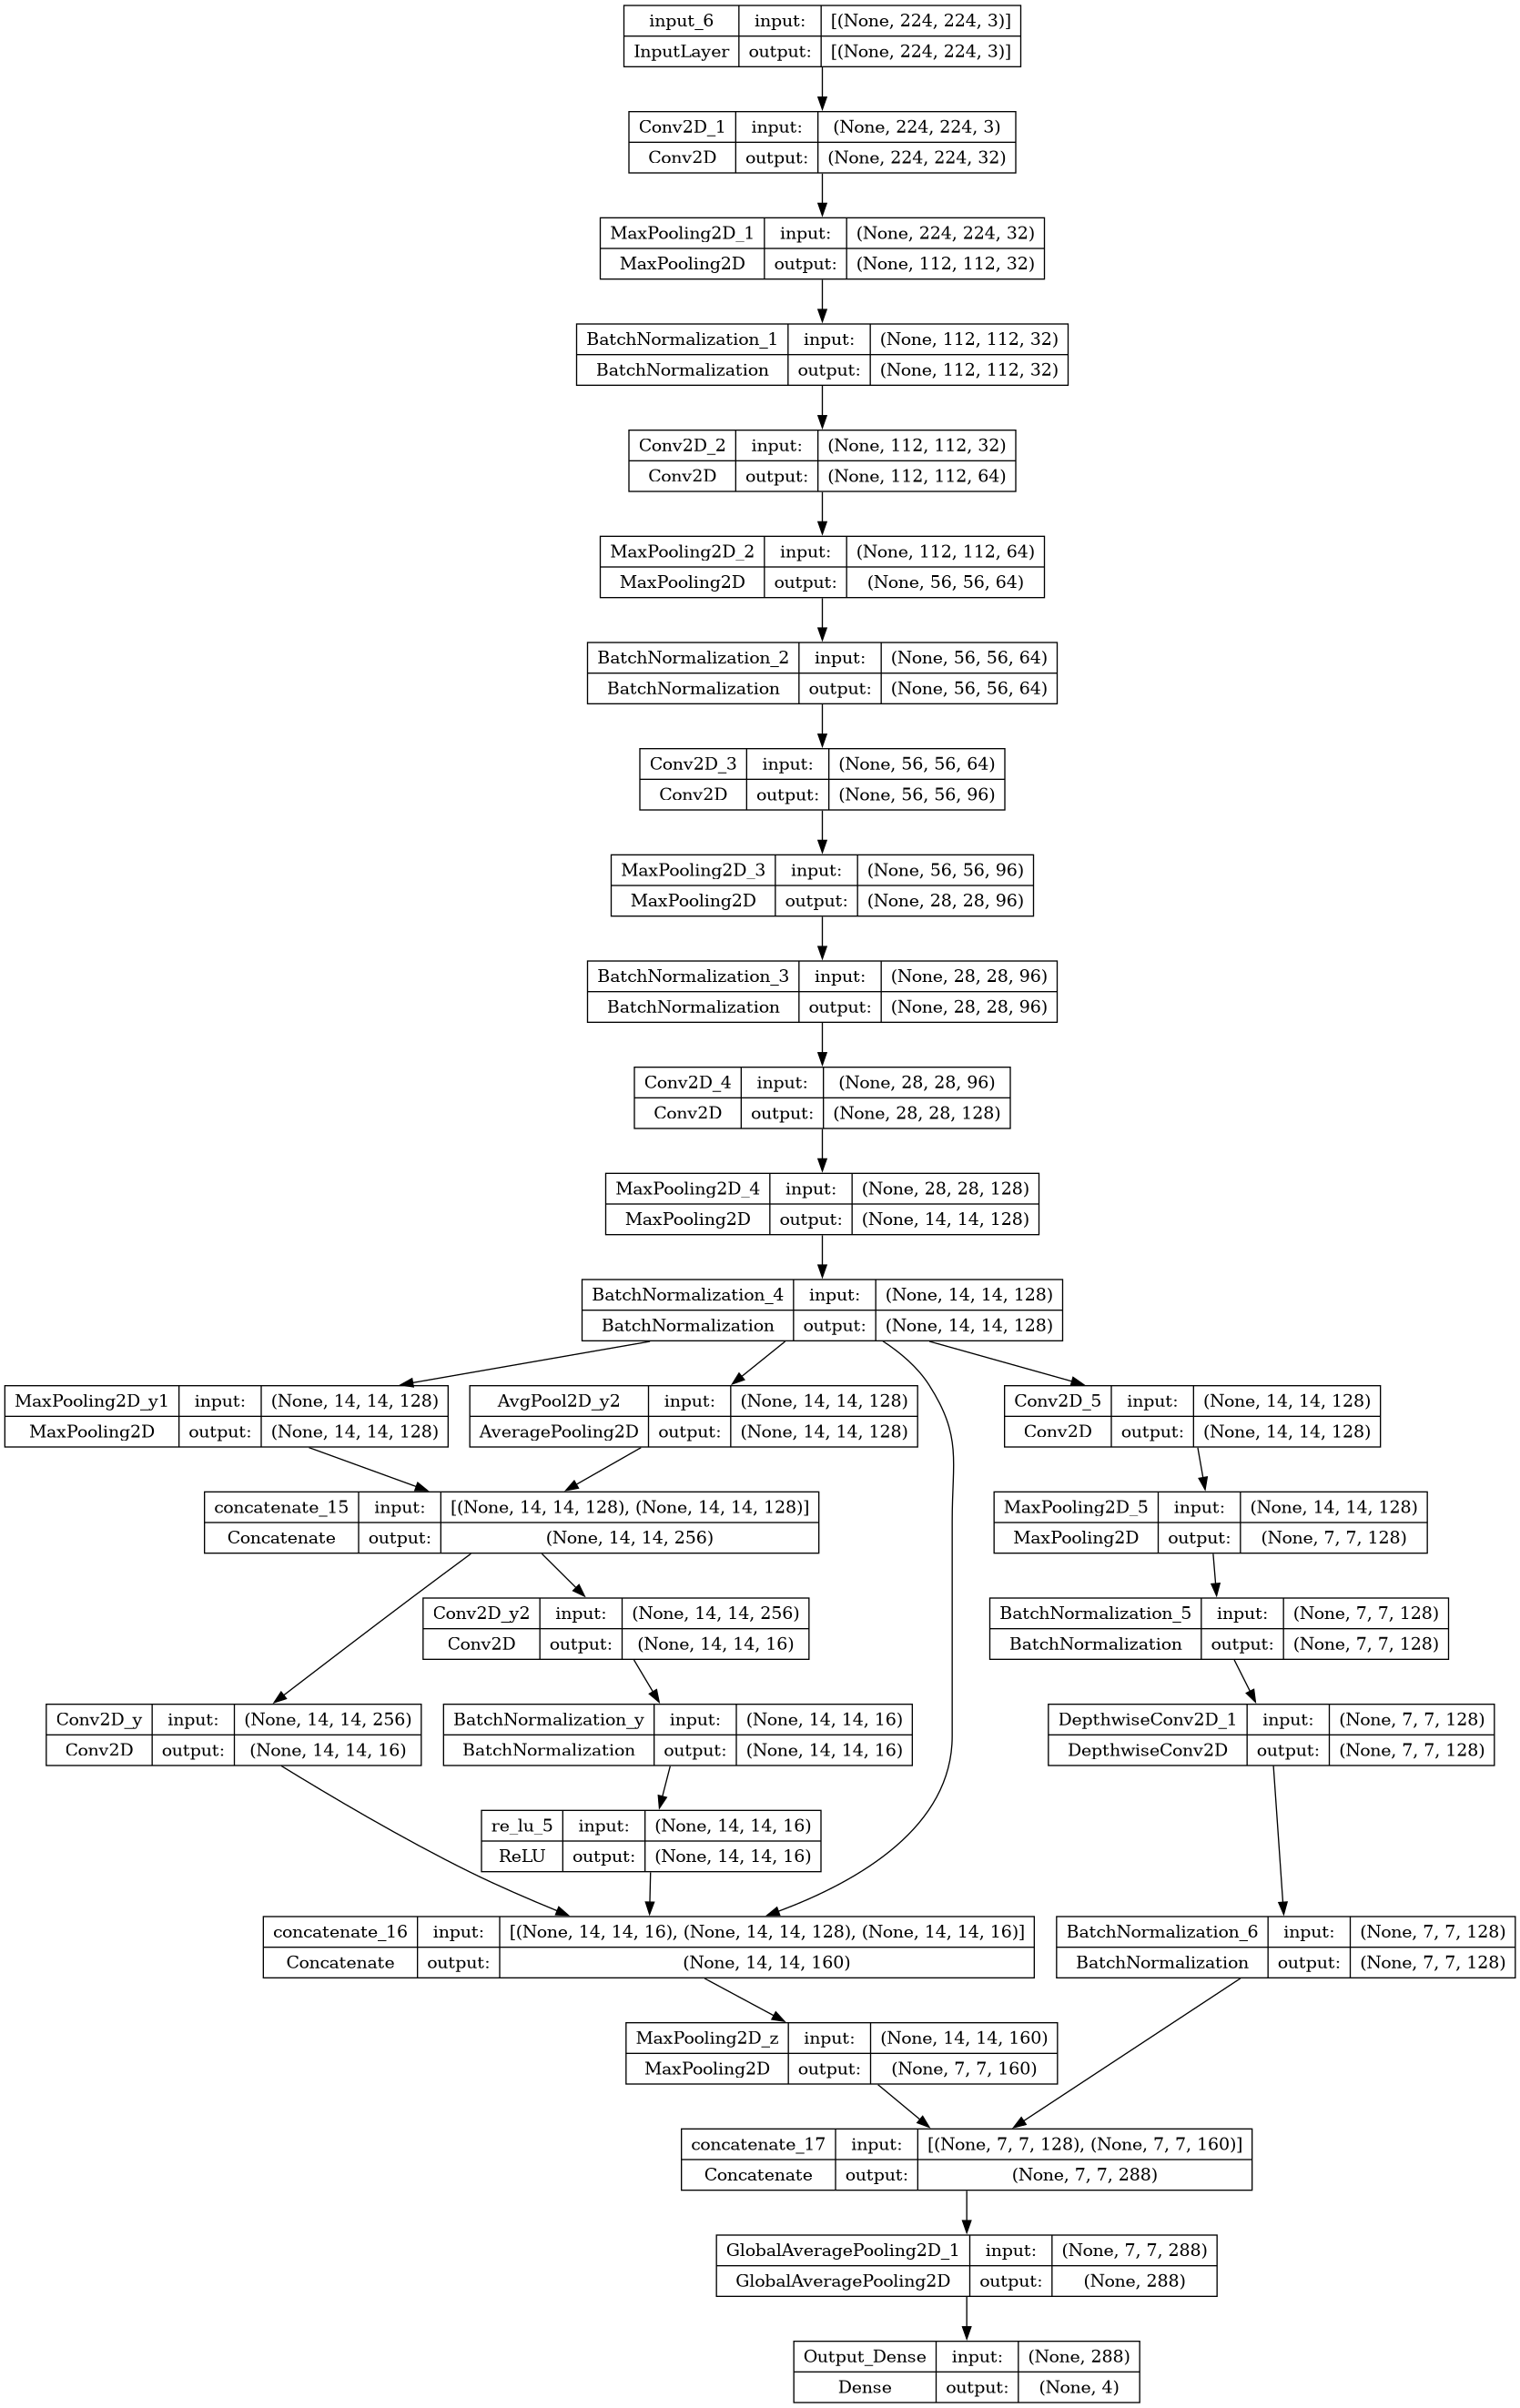

In [50]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [51]:
import keras.backend as K

def create_metrics():
    """
    Creates instances of various metrics for evaluating model performance.

    Returns:
        tuple: A tuple of the metrics: (recall, precision, f1_score, auc, sensitivity, specificity, mcc).
    """
    @tf.function
    def f1_score(y_true, y_pred):
        """
        Calculates the F1 score.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: F1 score.
        """
        tp = true_positive(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        precision = tp / (tp + fp + K.epsilon())
        recall = tp / (tp + fn + K.epsilon())

        return 2 * (precision * recall) / (precision + recall + K.epsilon())

    @tf.function
    def specificity(y_true, y_pred):
        """
        Calculates the specificity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Specificity.
        """
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)

        return tn / (tn + fp + K.epsilon())

    @tf.function
    def sensitivity(y_true, y_pred):
        """
        Calculates the sensitivity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Sensitivity.
        """
        tp = true_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        return tp / (tp + fn + K.epsilon())

    @tf.function
    def mcc(y_true, y_pred):
        """
        Calculates the Matthews correlation coefficient (MCC).

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Matthews correlation coefficient.
        """
        tp = true_positive(y_true, y_pred)
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        numerator = (tp * tn - fp * fn)
        denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

        return numerator / (denominator + K.epsilon())

    @tf.function
    def true_positive(y_true, y_pred):
        """
        Calculates the number of true positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true positives.
        """
        y_pred_pos, _, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_pos)

    @tf.function
    def false_positive(y_true, y_pred):
        """
        Calculates the number of false positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false positives.
        """
        y_pred_pos, _, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_pos)

    @tf.function
    def false_negative(y_true, y_pred):
        """
        Calculates the number of false negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false negatives.
        """
        _, y_pred_neg, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_neg)

    @tf.function
    def true_negative(y_true, y_pred):
        """
        Calculates the number of true negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true negatives.
        """
        _, y_pred_neg, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_neg)

    @tf.function
    def calculate_confusion_matrix(y_true, y_pred):
        """
        Calculates the components of the confusion matrix.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            tuple: A tuple containing the components of the confusion matrix: (y_pred_pos, y_pred_neg, y_pos, y_neg).
        """
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.round(K.clip(y_true, 0, 1))
        y_neg = 1 - y_pos
        return y_pred_pos, y_pred_neg, y_pos, y_neg

    precision = Precision()
    recall = Recall()
    f1_score = f1_score
    specificity = specificity
    sensitivity = sensitivity
    mcc = mcc
    auc = AUC()

    return (
        precision,
        recall,
        f1_score,
        specificity,
        sensitivity,
        mcc,
        auc,
    )

In [52]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', create_metrics()])

In [53]:
from time import perf_counter

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

optimizer_ad = Adam(learning_rate=initial_learning_rate)

start_time = perf_counter()

history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[lr_callback, early_stopping_callback]
)
end_time = perf_counter()

Epoch 1/20
430/430 [==============================] - 24s 40ms/step - loss: 0.6217 - accuracy: 0.7466 - precision_4: 0.8011 - recall_4: 0.6783 - f1_score: 0.7288 - specificity: 0.9439 - sensitivity: 0.6782 - mcc: 0.6563 - auc_4: 0.9333 - val_loss: 0.4780 - val_accuracy: 0.8331 - val_precision_4: 0.8652 - val_recall_4: 0.7784 - val_f1_score: 0.8159 - val_specificity: 0.9586 - val_sensitivity: 0.7756 - val_mcc: 0.7614 - val_auc_4: 0.9653 - lr: 0.0010
Epoch 2/20
430/430 [==============================] - 15s 35ms/step - loss: 0.2632 - accuracy: 0.9059 - precision_4: 0.9186 - recall_4: 0.8914 - f1_score: 0.9043 - specificity: 0.9736 - sensitivity: 0.8914 - mcc: 0.8736 - auc_4: 0.9885 - val_loss: 0.1965 - val_accuracy: 0.9538 - val_precision_4: 0.9600 - val_recall_4: 0.9497 - val_f1_score: 0.9514 - val_specificity: 0.9857 - val_sensitivity: 0.9463 - val_mcc: 0.9354 - val_auc_4: 0.9938 - lr: 0.0010
Epoch 3/20
430/430 [==============================] - 15s 35ms/step - loss: 0.1177 - accuracy:

In [54]:
execution_time = end_time - start_time

milliseconds = int(execution_time * 1000)
seconds, milliseconds = divmod(milliseconds, 1000)
minutes, seconds = divmod(seconds, 60)
hours, minutes = divmod(minutes, 60)

time_string = f"{hours} hours, " if hours else ""
time_string += f"{minutes} minutes, " if minutes else ""
time_string += f"{seconds} seconds, " if seconds else ""
time_string += f"{milliseconds} milliseconds"

print(f"Model training took {time_string}")

Model training took 3 minutes, 58 seconds, 719 milliseconds


In [55]:
_ = model.evaluate(X_test, y_test, verbose=2)

135/135 - 1s - loss: 0.1138 - accuracy: 0.9807 - precision_4: 0.9825 - recall_4: 0.9800 - f1_score: 0.9767 - specificity: 0.9927 - sensitivity: 0.9755 - mcc: 0.9690 - auc_4: 0.9979 - 1s/epoch - 11ms/step


In [56]:
import matplotlib.pyplot as plt
import math

def plot_metrics(hist, metric_name_list):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        hist: a Keras History object containing the training history
        metric_name_list: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_name_list)

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, len(hist.history[metric_name_list[0]]) + 1)

    for ax, metric_n in zip(axes, metric_name_list):
        metric = hist.history[metric_n]
        v_metric = hist.history[f"val_{metric_n}"]

        ax.plot(rng, metric, label=metric_n)
        ax.plot(rng, v_metric, label=f"val_{metric_n}")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_n in ("auc", "mcc"):
            ax.set_ylabel(metric_n.upper())
            ax.set_title(metric_n.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_n.capitalize())
            ax.set_title(metric_n.capitalize() + " vs Epochs")

        max_loss = max(max(metric), max(v_metric))
        min_loss = min(min(metric), min(v_metric))
        y_max = math.ceil(max_loss)

        if min_loss > 0 or max_loss > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_loss, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, len(metric))

    plt.tight_layout()

    plt.show()

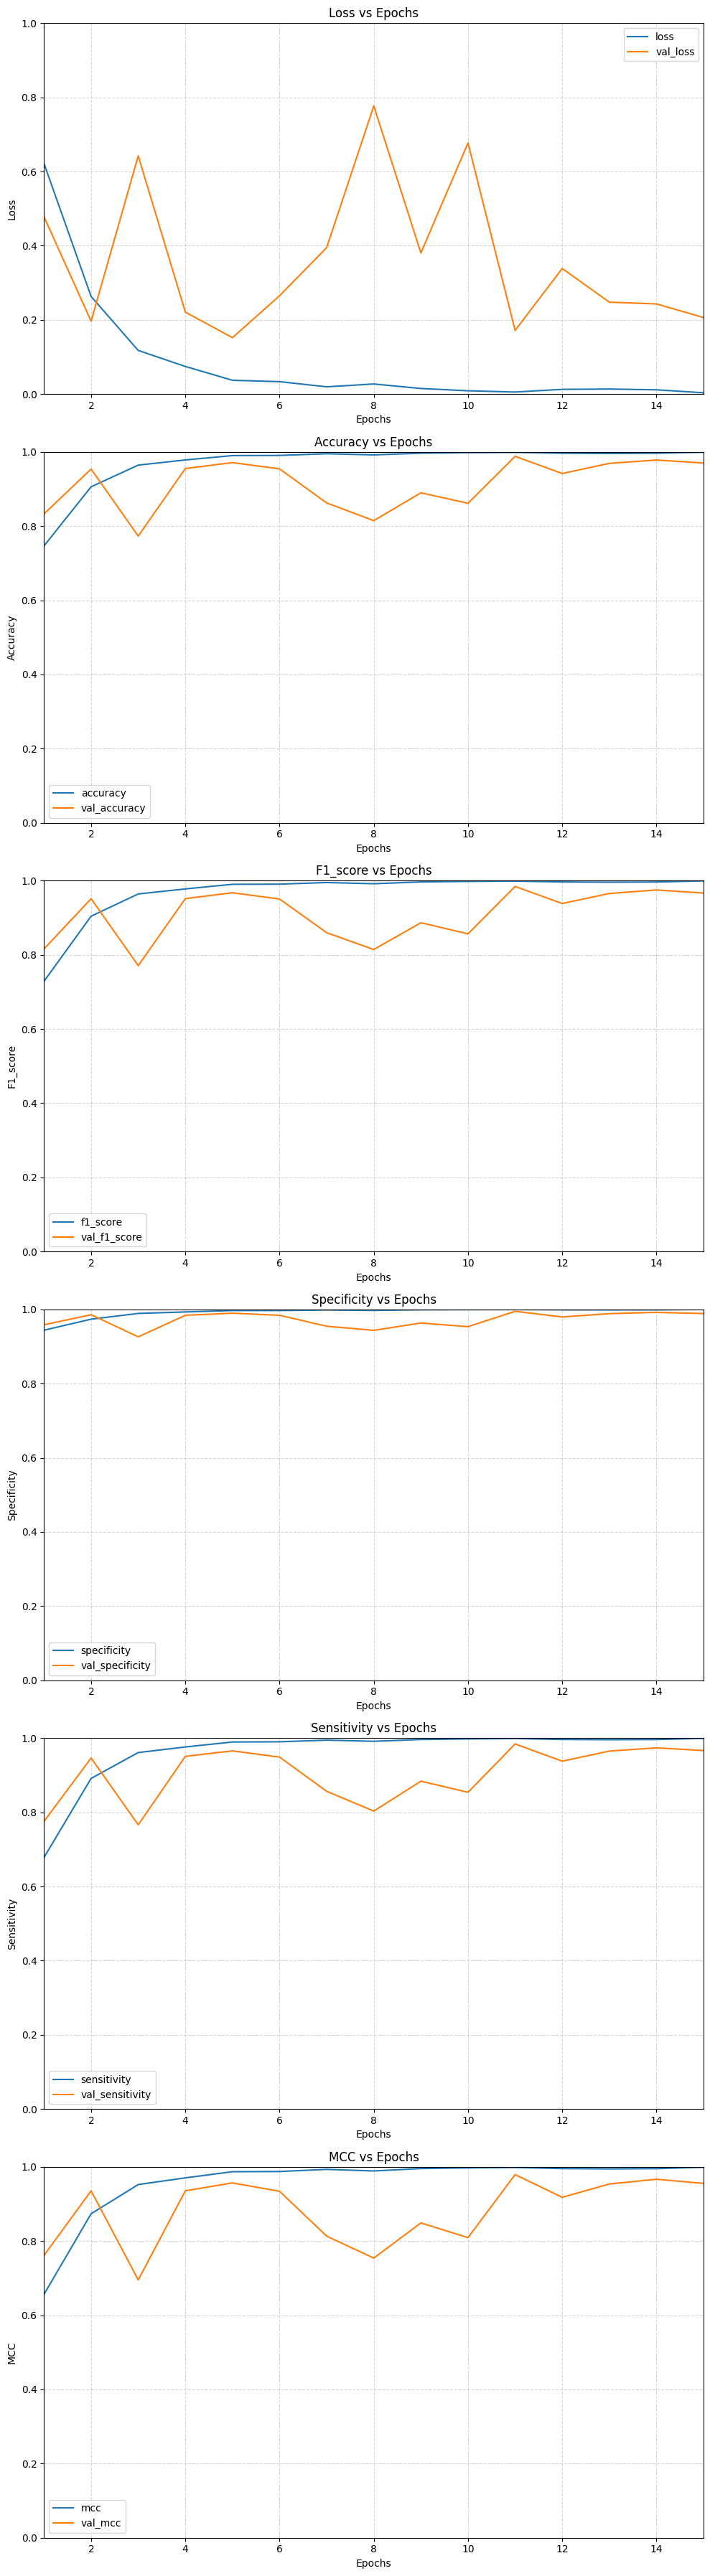

In [57]:
metric_names = ["loss", "accuracy","f1_score",
                "specificity", "sensitivity", "mcc"]
plot_metrics(history, metric_names)

135/135 [==============================] - 2s 9ms/step
                  precision    recall  f1-score   support

    MildDemented       0.97      1.00      0.98      1000
ModerateDemented       1.00      0.99      0.99        98
     NonDemented       0.98      0.99      0.98      1800
VeryMildDemented       0.99      0.96      0.98      1400

        accuracy                           0.98      4298
       macro avg       0.98      0.98      0.98      4298
    weighted avg       0.98      0.98      0.98      4298



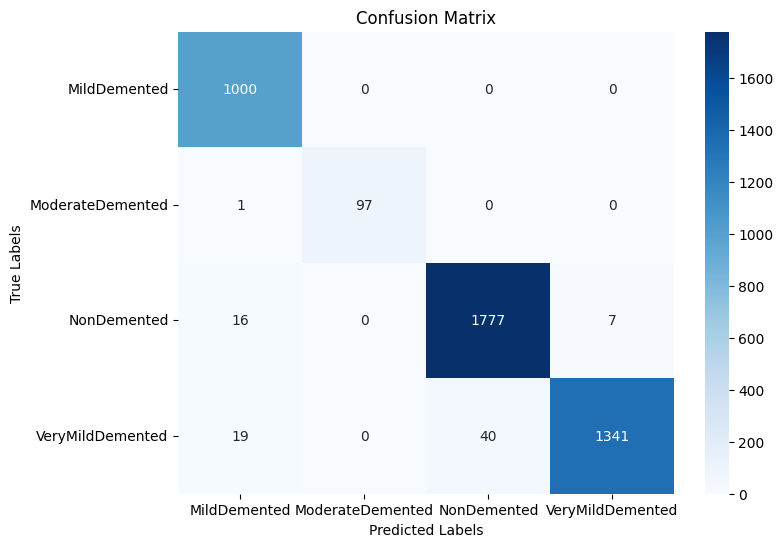

In [58]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Generate classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Determine unique classes present in predictions
unique_classes = np.unique(y_pred_classes)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
# Select class names corresponding to predicted classes
class_names = [class_names[i] for i in unique_classes]

# Assuming y_test is your one-hot encoded test labels
report = classification_report(np.argmax(y_test, axis=1), y_pred_classes, target_names=class_names)
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes) # Use y_test here as well

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()